In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("../..")
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *
from microlensing.lib.microlensing import *
from mfilter.vetoes.chisquare import *

%matplotlib inline
plt.style.use('seaborn')

In [69]:
# generating time samples
def time_irreg_samples(n=100, basic_dt=1, struct="slight"):
    return TimesSamples(n=n, delta=basic_dt, struct=struct)

# creating templates
def mlens_temp(times, pars, idx=0, t0=None, skip=5):
    if t0 is None:
        t0 = np.random.choice(times[skip:len(times)-skip])
    else:
        t0 = times[np.argmin(abs(times - t0))]
    ml = microlens(tE=pars['tE'][idx], U0=pars['U0'][idx], fs=pars['fs'][idx], t0=t0)
    return TimeSeries(ml.eval(times), times=times), t0


# generate parameter generator object and sample parameters
parfile = "test.txt" # here put your favourite file with columns tE, U0 and fs, in data directory
pargen = microlens_pars(parsfile = "../../microlensing/data/%s" % parfile)
nsample = 100
pars = pargen.sample(nsample)

In [3]:
def one_run(times, pars, nsample, noise_level=0.5, idx=None, t0=None, 
            chi=False, band=False, window=False, psd=None):
    if idx is None:
        idx = np.random.randint(1, nsample)
    data, t0 = mlens_temp(times, pars, idx=idx, t0=t0)
    while (any(np.isnan(d) for d in data)):
        idx = np.random.randint(1, nsample)
        data, t0 = mlens_temp(times, pars, idx=idx, t0=t0)
    data += np.random.normal(0, noise_level*abs(min(data)), n)
    temp, _ = mlens_temp(times, pars, idx=idx, t0=times[n//2])
    gamma = 0.3
    data += gamma
    temp += gamma
    
    if band:
        cutoff = 0.2
        bb, ab = signal.butter(3, cutoff*2 * len(times)/times.duration, btype='lowpass', analog=False)
        data = TimeSeries(signal.filtfilt(bb, ab, data), times=times)
        temp = TimeSeries(signal.filtfilt(bb, ab, temp), times=times)
        
    if window:
        data -= gamma
        temp -= gamma
        wind = signal.windows.hann(len(times))
        wind = signal.windows.tukey(len(times), alpha=1/8)
        data *= wind
        temp *= wind
        data += gamma
        temp += gamma
    # create regresssors
    nyq = 1 / (2 * delta_t)
    samples_per_peak = 5
    df = 1 / times.duration / samples_per_peak
    freqs = FrequencySamples(input_time=times,
                        minimum_frequency=samples_per_peak * df,
                        maximum_frequency=nyq + samples_per_peak * df,
                        samples_per_peak=samples_per_peak)
    F = Dictionary(times, freqs)
    print(F.splited_matrix.shape)
    reg = RidgeRegression(alpha=10**(-6), phi=F)
    reg = SGDRegression(alpha=10**(-3), max_iter=100, phi=F)

    # compute transforms with regressors
    t_i = time.time()
    stilde_reg = data.to_frequencyseries(method="regression", reg=reg)
    htilde_reg = temp.to_frequencyseries(method="regression", reg=reg)
    t_f = time.time()
    print("time for reg", (t_f-t_i))
    
    #lets use psd related to same noise distribution
#     psd_reg = freqs.lomb_scargle(times, np.random.normal(0, 0.1, n), norm="standard")
            
    # do MF for regressors
    t_i = time.time()
    snr_reg = matched_filter(htilde_reg, stilde_reg, psd=psd, method="regression", reg=reg, 
                        times=times, unitary_energy=True)
    t_f = time.time()
    print("time for reg is", (t_f-t_i))
    if chi:
        divs = 40
        chsq_reg, n_bins = power_chisq(htilde_reg, stilde_reg, divs, times, reg=reg)
        chsq_reg /= (n_bins * 2) - 2
    
        snr_reg = weighted_snr(snr_reg, chsq_reg)
    return data, temp, snr_reg, t0, idx

(101, 720)
time for reg 0.01641559600830078
time for reg is 0.14297795295715332


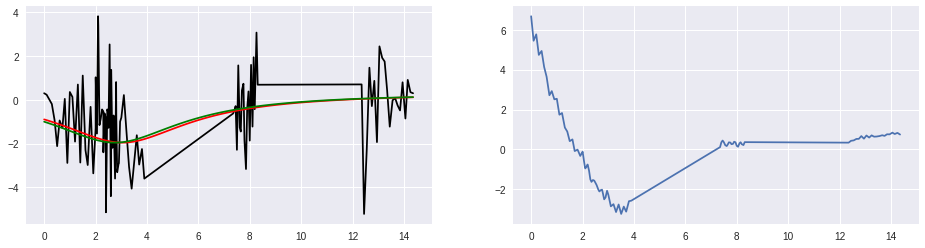

In [4]:
n = 101
delta_t = 0.1
times = time_irreg_samples(n=n, basic_dt=delta_t, struct="automix")
times -= min(times)

idx = None
window=True
chi=True
data, temp, snr_reg, true_t0, idx = one_run(times, pars, nsample, noise_level=0.8, idx=idx, window=window, chi=chi)
temp_times = np.linspace(times.min(), times.max(), 100)
temp_reg, _ = mlens_temp(TimesSamples(temp_times), pars, idx=idx, 
                         t0=(times[len(times)//2] - times[np.argmax(snr_reg.real)]) % times.duration)
temp_reg += 0.3
real_temp, _ = mlens_temp(TimesSamples(temp_times), pars, idx=idx,
                         t0=true_t0)
real_temp += 0.3
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(times, data, 'k', label="data")
ax1.plot(temp_times, temp_reg, 'r', label="matched temp")
ax1.plot(temp_times, real_temp, 'g', label="real temp")
ax2.plot(times, snr_reg.real)

### Aliasing
first we are going to try to cuantify the error introduced by the aliasing, for this, we tested

* error for match calculation over the same signal with same peak t0 but different time sampling
* error of noise, for this we use same sampling, same signal, same t0 but different noise lvl
* error of whitening, for this we introduce the PSD and repeat previous.



In [70]:
def create_data(times, pars, nsamples, idx=None, displaced=None, 
                t0=None, noise_level=0.1, noise_fixed=False, skip=5):
    if idx is None:
        idx = np.random.randint(1, nsample)
    data, t0 = mlens_temp(times, pars, idx=idx, t0=t0, skip=skip)
    while (any(np.isnan(d) for d in data)) or min(data) > -0.5:
        idx = np.random.randint(1, nsample)
        data, _ = mlens_temp(times, pars, idx=idx, t0=t0, skip=skip)
    
    if displaced is not None:
        data += displaced
        
    if not noise_fixed:
        noise_level = abs(data.max() - data.min())*noise_level
        
    noise = np.random.normal(0, noise_level, len(times))
    data += noise
    return data, idx, t0

def precission_time(N, n, delta_t, pars, nsamples, t0=None, idx=None, use_psd=False, chi=False, window=False,
                   band_passing=False, struct="slight"):
    
    alpha = None
    match_t0 = []
    data_t0 = []
    temp_t0 = []
    snrs = []
    duration = 0
    aux_times = np.zeros(n)
#     plt.figure()
    for i in range(N):
        print("runing {} of {}".format(i, N), end="\r")
        times = time_irreg_samples(n=n, basic_dt=delta_t, struct=struct)
        times -= min(times)
#         print(times == aux_times)
        aux_time = time
        data, idx, t0_data = create_data(times, pars, nsamples, idx=idx, t0=t0, noise_fixed=True)
        temp, _ = mlens_temp(times, pars, idx=idx, t0=times.duration//2)
        snr, alpha = run_match(times, data, temp, alpha=alpha, use_psd=use_psd, chi=chi, 
                        window=window, band_passing=band_passing)
#         print(times[np.argmax(snr.real)], t0, idx)
        match_t0.append(times[np.argmax(snr.real)])
        data_t0.append(t0_data)
        temp_t0.append(times.duration//2)
        snrs.append(snr)
        duration += times.duration
#         if abs(t0 - times[np.argmax(snr.real)] - t0) < tol * times.duration:
#             goods += 1
#         plt.plot(times, data, 'k', alpha=0.5)
#     plt.plot(times, temp)
    return idx, data_t0, match_t0, duration/N, snrs, temp_t0
        
        
def run_match(times, data, temp, alpha=None, use_psd=False, chi=False, window=False, band_passing=False,
             overfit=False):
    if band_passing:
        cutoff = 0.5 # between 0 and 1, adapted
        bb, ab = signal.butter(3, cutoff, btype='lowpass', analog=False)
        data = TimeSeries(signal.filtfilt(bb, ab, data), times=times)
        temp = TimeSeries(signal.filtfilt(bb, ab, temp), times=times)
        
    gamma = np.median(data)
    if window:
        data -= gamma
        wind = signal.windows.tukey(len(times), alpha=1/8)
        data *= wind
        temp *= wind
        data += gamma
        temp += gamma
    
    # create regresssors
    nyq = 1 / (2 * delta_t)
    samples_per_peak = 5
    df = 1 / times.duration / samples_per_peak
    freqs = FrequencySamples(input_time=times,
                        minimum_frequency=samples_per_peak * df,
                        maximum_frequency=nyq + samples_per_peak * df,
                        samples_per_peak=samples_per_peak)
    F = Dictionary(times, freqs)
    if alpha is None:
        reg, stilde, alpha = overfit_regressor(data, 10**(-3), F, max_iter=100)
    else:
        reg = SGDRegression(alpha=alpha, max_iter=100, phi=F)
        stilde = data.to_frequencyseries(method="regression", reg=reg)
        
    htilde = temp.to_frequencyseries(method="regression", reg=reg)
    
    if use_psd:
        seg_n = len(data)//10
        psd = freqs.lomb_welch(times, data, seg_n, 0.5)
    else:
        psd = None
        
    snr = matched_filter(htilde, stilde, psd=psd, method="regression", reg=reg, 
                         times=times, unitary_energy=True)
    
    if chi:
        divs = 40
        chsq, n_bins = power_chisq(htilde, stilde, divs, times, reg=reg)
        chsq /= (n_bins * 2) - 2
    
        snr = weighted_snr(snr, chsq)
        
    return snr, alpha

def overfit_regressor(data, alpha, phi, max_iter=100, last_r=0):
    import pdb
#     pdb.set_trace()
    
    score = -1
    best_alpha = alpha
    counter = 0
    while score < 0.8:
        if counter == 50:
            break
        reg = SGDRegression(alpha=alpha, max_iter=max_iter, phi=phi)
        stilde = data.to_frequencyseries(method="regression", reg=reg)
        score = reg.score(data)
        best_alpha = alpha
        alpha /= 10**(0.05)
        counter += 1
    reg = SGDRegression(alpha=best_alpha, max_iter=max_iter, phi=phi)
    stilde = data.to_frequencyseries(method="regression", reg=reg)
    return reg, stilde, best_alpha


In [71]:
#slightly irregular sampling

tols = [0.01, 0.02, 0.03, 0.04, 0.06, 0.1, 0.2, 0.3, 0.5]
idx = None
t0=None
idx, data_t0, match_t0, times_duration, _, temp_t0 = precission_time(100, n, delta_t, pars, nsample, 
                                                    idx=idx, t0=t0, struct="slight")
good_ones = []
for tol in tols:
#     print("runing {} of {}".format(i, len(tols)), end="\r")
    goods = 0
    for i in range(len(match_t0)):
        if abs(data_t0[i] - match_t0[i] - temp_t0[i]) < tol * times_duration:
            goods += 1
    good_ones.append(goods)

print(np.std(match_t0), np.mean(match_t0), np.median(match_t0))

2.929645730130024 3.4394270089430803 2.2997609495488165


In [72]:
#highly irregular sampling

tols = [0.01, 0.02, 0.03, 0.04, 0.06, 0.1, 0.2, 0.3, 0.5]
t0 = None
idx, data_t0, match_t0_mix, times_duration_mix, _, temp_t0 = precission_time(100, n, delta_t, pars, nsample, 
                                                    idx=idx, t0=t0, struct="automix")
good_ones_mix = []
for tol in tols:
#     print("runing {} of {}".format(i, len(tols)), end="\r")
    goods = 0
    for i in range(len(match_t0_mix)):
        if abs(data_t0[i] - match_t0_mix[i] - temp_t0[i]) < tol * times_duration_mix:
            goods += 1
    good_ones_mix.append(goods)

print(np.std(match_t0_mix), np.mean(match_t0_mix), np.median(match_t0_mix))

3.4347637734756007 2.688191987613072 0.0


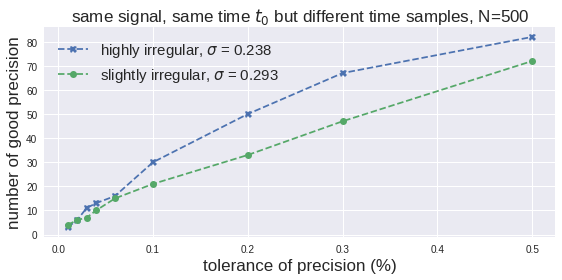

In [73]:
plt.figure(figsize=(8,4))
plt.plot(tols, good_ones_mix, 'X--', 
         label=r"highly irregular, $\sigma$ = {}".format(round(np.std(match_t0_mix)/times_duration_mix, 3)))
plt.plot(tols, good_ones, 'o--', 
         label=r"slightly irregular, $\sigma$ = {}".format(round(np.std(match_t0)/times_duration, 3)))
plt.title(r"same signal, same time $t_0$ but different time samples, N=500", fontsize=17)
plt.xlabel("tolerance of precision (%)", fontsize=17)
plt.ylabel("number of good precision", fontsize=17)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("detect_over_tols_mix.png")


In [74]:
#high irregular sampling
tols = [0.01, 0.02, 0.03, 0.04, 0.06, 0.1, 0.2, 0.3, 0.5]
deltas = [delta_t, delta_t*5, delta_t*10, delta_t*50, delta_t*100]
#slightly irregular sampling

t0 = None
good_ones_mix_deltas = {}
for dt in deltas:
    idx, data_t0, match_t0_mix_dt, times_duration, _, temp_t0 = precission_time(100, n, dt, pars, nsample, 
                                                    idx=idx, t0=t0, struct="automix")
    good_ones_mix_aux = []
    for tol in tols:
#         print("runing {} of {}".format(i, len(tols)), end="\r")
        goods = 0
        for i in range(len(match_t0_mix_dt)):
            if abs(data_t0[i] - match_t0_mix_dt[i] - temp_t0[i]) < tol * times_duration:
                goods += 1
        good_ones_mix_aux.append(goods)
    good_ones_mix_deltas[dt] = good_ones_mix_aux


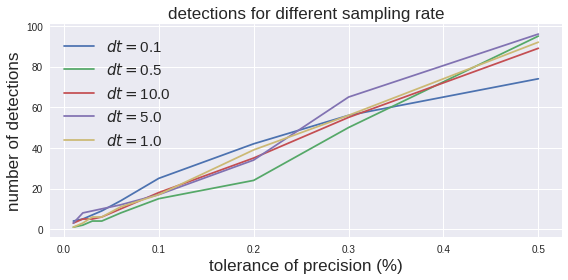

In [68]:
plt.figure(figsize=(8, 4))
for k, v in good_ones_mix_deltas.items():
    plt.plot(tols, v, label=r"$dt = $" + str(k))
    
plt.title("detections for different sampling rate", fontsize=17)
plt.xlabel("tolerance of precision (%)", fontsize=17)
plt.ylabel("number of detections", fontsize=17)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("precision_for_deltas.png", dpi=300)

In [47]:
# thresholds
def repeats(N, n, delta_t, pars, nsample, struct="slight", 
            noise_level=0.1, use_psd=True, chi=False, window=False, band_passing=False):
    alpha = None
    match_t0 = []
    basic_t0 = []
    temp_t0 = []
    snrs = []
    duration = 0
    depth = []
    for i in range(N):
        print("runing {} of {}".format(i, N), end="\r")
        times = time_irreg_samples(n=n, basic_dt=delta_t, struct=struct)
        times -= min(times)
        data, idx, t0_data = create_data(times, pars, nsample, idx=None, t0=None,
                                    noise_level=noise_level, noise_fixed=True, skip=len(times)//10)
        temp, _ = mlens_temp(times, pars, idx=idx, t0=times.duration/2)
        if min(temp) > -0.5:
            continue
        else:
            depth.append(min(temp))
            snr, alpha = run_match(times, data, temp, alpha=alpha, use_psd=use_psd, chi=chi, 
                        window=window, band_passing=band_passing)
            basic_t0.append(t0_data)
            match_t0.append(times[np.argmax(snr.real)])
            temp_t0.append(times.duration/2)
            snrs.append(snr)
            duration += times.duration
#         if abs(t0 - times[np.argmax(snr.real)] - t0) < tol * times.duration:
#             goods += 1
#         plt.plot(times, data, 'k', alpha=0.5)
#     plt.plot(times, temp)
        
        
    return basic_t0, match_t0, duration/N, snrs, temp_t0, depth


data_t0, match_t0_thrs, times_duration, snrs, temp_t0, depth_temps = repeats(100, n, delta_t, pars, nsample, 
                                                       struct="automix", noise_level=0.05)
tol = 0.05
thresholds = [0.3, 0.5, 0.7, 0.8, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 3, 5]
goods_thrs = []
goods_match = []

for thrs in thresholds:
    good_aux = 0
    good_aux2 = 0
    for i in range(len(match_t0_thrs)):
        if abs(data_t0[i] - match_t0_thrs[i] - temp_t0[i]) < tol * times_duration:
            good_aux2 += 1
            if np.max(snrs[i]) >= thrs:
                good_aux += 1
    goods_thrs.append(good_aux)
    goods_match.append(good_aux2)
    


../../microlensing/lib/microlensing.py:24: RuntimeWarning: divide by zero encountered in true_divide
  u = np.sqrt(self.U0**2 + ((times - self.t0)  /self.tE )**2)
../../microlensing/lib/microlensing.py:24: RuntimeWarning: invalid value encountered in true_divide
  u = np.sqrt(self.U0**2 + ((times - self.t0)  /self.tE )**2)
../../microlensing/lib/microlensing.py:25: RuntimeWarning: invalid value encountered in true_divide
  A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))


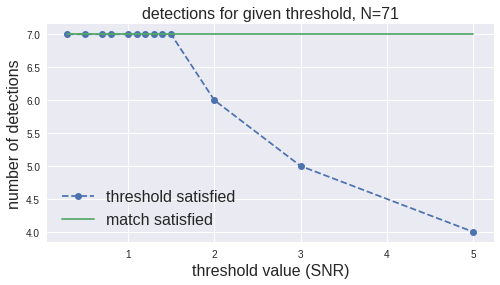

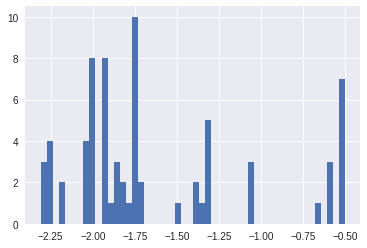

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, goods_thrs, '--o', label="threshold satisfied")
plt.plot(thresholds, goods_match, '-',label="match satisfied")
plt.title("detections for given threshold, N={}".format(len(data_t0)), fontsize=16)
plt.xlabel("threshold value (SNR)", fontsize=16)
plt.ylabel("number of detections", fontsize=16)
plt.legend(fontsize=16)
plt.savefig("threshold.png", dpi=300)


plt.figure()
_ = plt.hist(depth_temps, bins=50)

In [ ]:
# run for different error levels

noise_levels = [0.2, 0.4, 0.8, 1, 2]
thresholds = [0.7, 0.9, 1, 1.2, 1.5, 1.8, 2.1, 3]
t0 = None
good_ones_mix_thrs_nlvl = {}
for nlvl in noise_levels:
    data_t0, match_t0_thrs, times_duration, snrs, temp_t0 = repeats(500, n, delta_t, pars, nsample, 
                                                           noise_level=nlvl, struct="automix")
    goods_thrs = []
    goods_match = []
    for thrs in thresholds:
        good_aux = 0
        good_aux2 = 0
        for i in range(len(match_t0_thrs)):
            if abs(data_t0[i] - match_t0_thrs[i] - temp_t0[i]) < tol * times_duration:
                good_aux2 += 1
                if np.max(snrs[i]) >= thrs:
                    good_aux += 1
        goods_thrs.append(good_aux)
        goods_match.append(good_aux2)
    good_ones_mix_thrs_nlvl[nlvl] = goods_thrs
    

    

In [ ]:
good_ones_mix_thrs_nlvl

In [ ]:
plt.figure(figsize=(8, 4))
for k, v in good_ones_mix_thrs_nlvl.items():
#     print(v)
    plt.plot(thresholds, v, label=r"$\sigma = $ {}".format(round(k, 3)))

plt.title("detection for thresholds using different noise levels, N=500", fontsize=16)
plt.xlabel("threshold (SNR)",fontsize=16)
plt.ylabel("number of detections", fontsize=16)
plt.legend(fontsize=15)
plt.savefig("diff_noise_thrs_det.png", dpi=300)

In [ ]:
#highly irregular sampling

tols = [0.01, 0.02, 0.03, 0.04, 0.06, 0.1, 0.2, 0.3, 0.5]

good_ones_mix = []
# idx = None
i = 1
idx = None
t0=None
matchs_t0_mix = []
for tol in tols:
    times = time_irreg_samples(n=n, basic_dt=delta_t, struct="automix")
    times -= min(times)
    print("runing {} of {}".format(i, len(tols)), end="\r")
    goods, idx, t0, match_t0 = precission_time(100, times, pars, nsample, idx=idx, t0=t0, tol=tol)
    good_ones_mix.append(goods)
    matchs_t0_mix.extend(match_t0)
    i += 1

print(np.std(matchs_t0_mix), np.mean(matchs_t0_mix), np.median(matchs_t0_mix))
plt.plot(tols, good_ones_mix)

In [ ]:
#slightly irregular sampling

deltas = [0.05, 0.1, 0.5, 1, 1.5, 2, 3, 4, 6]
good_ones_deltas_mix = []
# idx = None
i = 1
idx = None
t0=None
tol=0.03
matchs_t0_deltas_mix = []
for dt in deltas:
    times = time_irreg_samples(n=n, basic_dt=dt, struct="slight")
    times -= min(times)
    print("runing {} of {}".format(i, len(tols)), end="\r")
    goods, idx, t0, match_t0 = precission_time(100, times, pars, nsample, idx=idx, t0=t0, tol=tol)
    good_ones_deltas_mix.append(goods)
    matchs_t0_deltas_mix.extend(match_t0)
    i += 1

print(np.std(matchs_t0_deltas_mix), np.mean(matchs_t0_deltas_mix), np.median(matchs_t0_deltas_mix))
plt.plot(deltas, good_ones_deltas_mix)

In [ ]:
# test the noise SNR to be distributed as 1
# different realization of noise should leads to same distribution

def dist(N, times, pars, nsamples, t0=None, idx=None, use_psd=False, 
         chi=False, window=False, band_passing=False, tol=0.01, noise_level=None):
    alpha = 0.0001
    v = []
    
    for i in range(N):
        data, idx, t0 = create_data(times, pars, nsamples, idx=idx, t0=t0, noise_level=noise_level)
        data = TimeSeries(np.random.normal(0, noise_level * abs(min(data.real)), len(times)), times=data.times)
        temp, _ = mlens_temp(times, pars, idx=idx, t0=t0)
        snr, alpha = run_match(times, data, temp, alpha=alpha, use_psd=use_psd, chi=chi, 
                        window=window, band_passing=band_passing)
        v.append(snr.real[5])
    return v, idx, t0

#slightly irregular sampling

noise_level = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
good_ones_deltas_mix = []
# idx = None
i = 1
idx = None
t0=None
tol=0.03
dists_per_nlvl_mean = []
dists_per_nlvl_std = []
for n_lvl in noise_level:
    times = time_irreg_samples(n=n, basic_dt=delta_t, struct="slight")
    times -= min(times)
    print("runing {} of {}".format(i, len(tols)), end="\r")
    v, idx, t0 = dist(100, times, pars, nsample, idx=idx, t0=t0, tol=tol, noise_level=n_lvl, use_psd=True)
    dists_per_nlvl_mean.append(np.mean(v))
    dists_per_nlvl_std.append(np.std(v))
    i += 1

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 3))
ax1.plot(noise_level, dists_per_nlvl_mean)
ax2.plot(noise_level, dists_per_nlvl_std)


In [ ]:
tols = [0.01, 0.02, 0.03, 0.04, 0.06, 0.1, 0.2, 0.3, 0.5]

good_ones = []
# idx = None
i = 1
idx = None
t0=None
matchs_t0 = []
t_i = time.time()
for tol in tols:
    times = time_irreg_samples(n=n, basic_dt=delta_t, struct="automix")
    times -= min(times)
    print("runing {} of {}".format(i, len(tols)), end="\r")
    goods, idx, t0, match_t0 = precission_time(100, times, pars, nsample, idx=idx, t0=t0, tol=tol)
    good_ones.append(goods)
    matchs_t0.extend(match_t0)
    i += 1
t_f = time.time()
print((t_f-t_i) / (500*len(tols)))
print(np.std(matchs_t0), np.mean(matchs_t0), np.median(matchs_t0))
plt.plot(tols, good_ones)

### presision testing
we are going to check what is the impact of doing
* band passing
* window
* chi-square veto

Also we are going to test some behaviors, in specific:
* how well does the match work for the time of the event
* how well the match work for different tresholds
* how well the match work for different levels of noise, i.e., the sensitivity of detections
* how well the match filter identify the real template


In [ ]:
# for testing the presicion of match for time of event we choose a mlens event with some presicion, then
# generate a noise that allow to detect the event (arbitrarly choose 30% of the peak) and on two types od grid, 
# slightly irregular and totally irregular (with chang ein spacing and empty windows of observations)

# def create_data(times, pars, nsamples, idx=None, displaced=None):
#     if idx is None:
#         idx = np.random.randint(1, nsample)
#     data, t0 = mlens_temp(times, pars, idx=idx)
#     while (any(np.isnan(d) for d in data)):
#         idx = np.random.randint(1, nsample)
#         data, _ = mlens_temp(times, pars, idx=idx, t0=t0)
    
#     if displaced is not None:
#         data += displaced
        
#     noise = np.random.normal(0, abs(data.min())*0.3, len(times))
#     data += noise
#     return data, idx, t0

# def precission_time(N, times, pars, nsamples, idx=None, use_psd=False, chi=False, window=False,
#                    band_passing=False, tol=0.01):
    
#     goods = 0
#     alpha = None
#     for i in range(N):
#         data, idx, t0 = create_data(times, pars, nsamples, idx=idx)
#         temp, _ = mlens_temp(times, pars, idx=idx, t0=times.duration/2 + times.min())
#         snr, alpha = run_match(times, data, temp, alpha=alpha, use_psd=use_psd, chi=chi, 
#                         window=window, band_passing=band_passing)
#         if abs(t0 - times[np.argmax(snr.real)]) < tol * times.duration:
#             goods += 1
            
#     return goods, idx
        
        
# def run_match(times, data, temp, alpha=None, use_psd=False, chi=False, window=False, band_passing=False,
#              overfit=False):
#     if band_passing:
#         cutoff = 0.5 # between 0 and 1, adapted
#         bb, ab = signal.butter(3, cutoff, btype='lowpass', analog=False)
#         data = TimeSeries(signal.filtfilt(bb, ab, data), times=times)
#         temp = TimeSeries(signal.filtfilt(bb, ab, temp), times=times)
        
#     gamma = np.median(data)
#     if window:
#         data -= gamma
#         wind = signal.windows.tukey(len(times), alpha=1/8)
#         data *= wind
#         temp *= wind
#         data += gamma
#         temp += gamma
    
#     # create regresssors
#     nyq = 1 / (2 * delta_t)
#     samples_per_peak = 5
#     df = 1 / times.duration / samples_per_peak
#     freqs = FrequencySamples(input_time=times,
#                         minimum_frequency=samples_per_peak * df,
#                         maximum_frequency=nyq + samples_per_peak * df,
#                         samples_per_peak=samples_per_peak)
#     F = Dictionary(times, freqs)
#     if alpha is None:
#         reg, stilde, alpha = overfit_regressor(data, 10**(-3), F, max_iter=100)
#     else:
#         reg = SGDRegression(alpha=alpha, max_iter=100, phi=F)
#         stilde = data.to_frequencyseries(method="regression", reg=reg)
        
#     htilde = temp.to_frequencyseries(method="regression", reg=reg)
    
#     if use_psd:
#         # do an estimation of psd
#         psd = None
#     else:
#         psd = None
        
#     snr = matched_filter(htilde, stilde, psd=psd, method="regression", reg=reg, 
#                          times=times, unitary_energy=True)
    
#     if chi:
#         divs = 40
#         chsq, n_bins = power_chisq(htilde, stilde, divs, times, reg=reg)
#         chsq /= (n_bins * 2) - 2
    
#         snr = weighted_snr(snr, chsq)
        
#     return snr, alpha

# def overfit_regressor(data, alpha, phi, max_iter=100, last_r=0):
#     import pdb
# #     pdb.set_trace()
    
#     score = -1
#     best_alpha = alpha
#     counter = 0
#     while score < 0.8:
#         if counter == 50:
#             break
#         reg = SGDRegression(alpha=alpha, max_iter=max_iter, phi=phi)
#         stilde = data.to_frequencyseries(method="regression", reg=reg)
#         score = reg.score(data)
#         best_alpha = alpha
#         alpha /= 10**(0.05)
#         counter += 1
#     reg = SGDRegression(alpha=best_alpha, max_iter=max_iter, phi=phi)
#     stilde = data.to_frequencyseries(method="regression", reg=reg)
#     return reg, stilde, best_alpha


In [ ]:
#slightly irregular sampling
# times = time_irreg_samples(n=n, basic_dt=delta_t, struct="slight")
# times -= min(times)

# tols = [0.01, 0.03, 0.07, 0.1, 0.13, 0.17, 0.2, 0.3, 0.5]

# good_ones = []
# # idx = None
# i = 1
# for tol in tols:
#     print("runing {} of {}".format(i, len(tols)), end="\r")
#     goods, idx = precission_time(50, times, pars, nsample, idx=idx, tol=tol)
#     good_ones.append(goods)
#     i += 1

In [ ]:
# huge irregularities
# times = time_irreg_samples(n=n, basic_dt=delta_t, struct="automix")
# times -= min(times)


# good_ones_mix = []
# i = 1
# for tol in tols:
#     print("runing {} of {}".format(i, len(tols)), end="\r")
#     goods, idx = precission_time(50, times, pars, nsample, idx=idx, tol=tol)
#     good_ones_mix.append(goods)
#     i += 1

In [ ]:
# with band passing, huge irregularities
# times = time_irreg_samples(n=n, basic_dt=delta_t, struct="automix")
# times -= min(times)

# good_ones_mix_band = []
# i = 1
# for tol in tols:
#     print("runing {} of {}".format(i, len(tols)), end="\r")
#     goods, idx = precission_time(50, times, pars, nsample, idx=idx, tol=tol, band_passing=True)
#     good_ones_mix_band.append(goods)
#     i += 1

In [ ]:
# with band passing, slight irregularities
# times = time_irreg_samples(n=n, basic_dt=delta_t, struct="slight")
# times -= min(times)

# good_ones_band = []
# i = 1
# for tol in tols:
#     print("runing {} of {}".format(i, len(tols)), end="\r")
#     goods, idx = precission_time(50, times, pars, nsample, idx=idx, tol=tol, band_passing=True)
#     good_ones_band.append(goods)
#     i += 1


In [ ]:
# with chi square, huge irregularities
# times = time_irreg_samples(n=n, basic_dt=delta_t, struct="automix")
# times -= min(times)

# good_ones_mix_chi = []
# i = 1
# for tol in tols:
#     print("runing {} of {}".format(i, len(tols)), end="\r")
#     goods, idx = precission_time(50, times, pars, nsample, idx=idx, tol=tol, chi=True)
#     good_ones_mix_chi.append(goods)
#     i += 1


In [ ]:
# with chi square, slight irregularities
# times = time_irreg_samples(n=n, basic_dt=delta_t, struct="slight")
# times -= min(times)

# good_ones_chi = []
# i = 1
# for tol in tols:
#     print("runing {} of {}".format(i, len(tols)), end="\r")
#     goods, idx = precission_time(50, times, pars, nsample, idx=idx, tol=tol, chi=True)
#     good_ones_chi.append(goods)
#     i += 1

In [ ]:
# with window, slight irreg
# times = time_irreg_samples(n=n, basic_dt=delta_t, struct="slight")
# times -= min(times)

# good_ones_wind = []
# i = 1
# for tol in tols:
#     print("runing {} of {}".format(i, len(tols)), end="\r")
#     goods, idx = precission_time(50, times, pars, nsample, idx=idx, tol=tol, window=True)
#     good_ones_wind.append(goods)
#     i += 1

In [ ]:
# with window, huge irreg
# times = time_irreg_samples(n=n, basic_dt=delta_t, struct="automix")
# times -= min(times)

# good_ones_mix_wind = []
# i = 1
# for tol in tols:
#     print("runing {} of {}".format(i, len(tols)), end="\r")
#     goods, idx = precission_time(50, times, pars, nsample, idx=idx, tol=tol, window=True)
#     good_ones_mix_wind.append(goods)
#     i += 1

In [ ]:
# fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# ax1.plot(tols, good_ones, 'r', label="direct match")
# ax1.plot(tols, good_ones_band, 'b', label="match with band passing")
# ax1.plot(tols, good_ones_chi, 'g', label="match with chi-square veto")
# ax1.plot(tols, good_ones_wind, 'k', label="match with window")
# ax1.legend()
# ax1.set_title("match filter with slight irregularities in time")
# ax1.set_xlabel("range of tolerance (%)")
# ax1.set_ylabel("number of good matchs")
# ax1.axhline(50, color="k")

# ax2.plot(tols, good_ones_mix, 'r')
# ax2.plot(tols, good_ones_mix_band, 'b')
# ax2.plot(tols, good_ones_mix_chi, 'g')
# ax2.plot(tols, good_ones_mix_wind, 'k')
# ax2.set_title("match filter with big irreg. in time")
# ax2.set_xlabel("range of tolerance (%)")
# ax2.axhline(50, color="k")

* threshold

In [ ]:
# def detections_over_threshold(N, times, pars, nsamples, use_psd=False, chi=False, window=False,
#                              band_passing=False, threshold=1):
    
#     goods = 0
#     alpha = None
#     for i in range(N):
#         data, idx, t0 = create_data(times, pars, nsamples, idx=None)
#         temp, _ = mlens_temp(times, pars, idx=idx, t0=times.duration/2 + times.min())
#         snr, alpha = run_match(times, data, temp, alpha=alpha, use_psd=use_psd, chi=chi, 
#                         window=window, band_passing=band_passing)
#         if threshold <= np.max(snr.real):
#             goods += 1
            
#     return goods, idx

In [ ]:
#slightly irregular sampling
# times = time_irreg_samples(n=n, basic_dt=delta_t, struct="slight")
# times -= min(times)

# threshold = [0.3, 0.4, 0.5, 0.7, 0.9, 1, 1.2, 1.4, 1.6, 2]

# good_ones = []
# # idx = None
# i = 1
# for thrsh in threshold:
#     print("runing {} of {}".format(i, len(tols)), end="\r")
#     goods, idx = detections_over_threshold(50, times, pars, nsample, threshold=thrsh)
#     good_ones.append(goods)
#     i += 1

In [ ]:
# plt.plot(threshold, good_ones)

In [9]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(max_iter)

In [12]:
hasattr(reg, 'loss')

True